## UFO Group Project

In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
UFO = Table.read_table('scrubbed.csv')

### Time Analysis
Step 1 - Split the datetime column into the hour of day, month, and year as a list

Step 2 - Convert the strings into numbers

Step 3 - Convert the list into columns within a new table

Step 4 - Create histograms

In [3]:
#Here I split the datetime column into the hour, month, and year
UFOtimes = list(UFO.column('datetime'))
time = [i.split(' ', 1)[-1] for i in UFOtimes]
hour = [i.split(':', 1)[0] for i in time]
date = [i.split(' ', 1)[0] for i in UFOtimes]
month = [i.split('/', 1)[0] for i in date]
year = [i.split('/')[-1] for i in date]

In [4]:
timestable = Table().with_columns('hour', hour, 'month', month, 'year', year)

In [5]:
#Here I convert all of the strings into integers
Year = timestable.column('year').astype(np.int)
Hour = timestable.column('hour').astype(np.int)
Month = timestable.column('month').astype(np.int)
timestable.append_column('Year', Year)
timestable.append_column('Month', Month)
timestable.append_column('Hour', Hour)
timestable.drop('hour','month','year')

Year,Month,Hour
1949,10,20
1949,10,21
1955,10,17
1956,10,21
1960,10,20
1961,10,19
1965,10,21
1965,10,23
1966,10,20
1966,10,21


### Time Analysis - Month

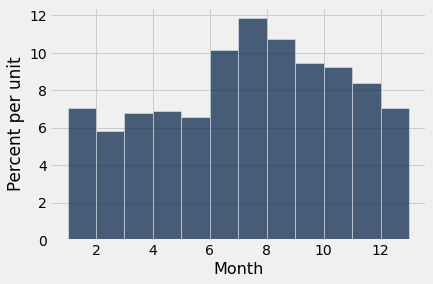

In [6]:
timestable.hist('Month', bins=np.arange(1,14,1))

Insights: Most sightings occur in July (12%). The least sightings occur in February (6%).

### Time Analysis - Hour

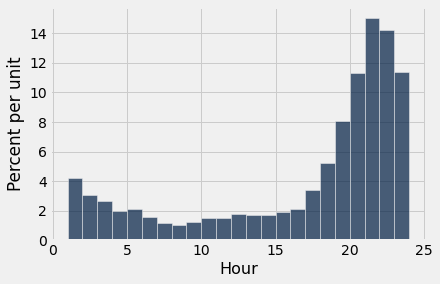

In [7]:
timestable.hist('Hour', bins=np.arange(1,25,1))

Insights: Most sightings occur in the evening. Specifically after 20:00, also known as 8PM.

### Time Analysis - Year

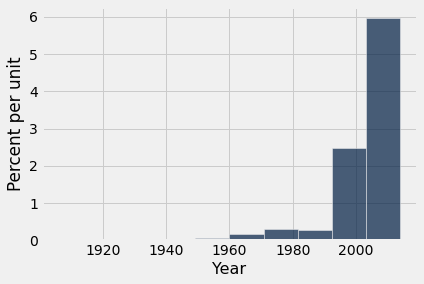

In [8]:
timestable.hist('Year')

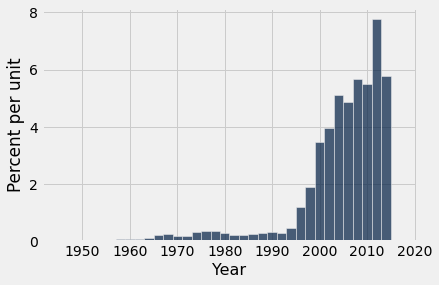

In [9]:
timestable.hist('Year', bins=np.arange(1945,2019,2))

In [10]:
timestable.group('Year').sort('count', descending = True)

Year,count
2012,7357
2013,7037
2011,5107
2008,4820
2009,4541
2010,4283
2007,4269
2004,4257
2005,4083
2003,3962


Insights: The most sightings happened in 2012. Coincidentally lining up with the end of the Mayan calendar? 

In [11]:
#Alice

shape_time = UFO.select('shape').append_column('Hour', Hour).pivot('shape', 'Hour')

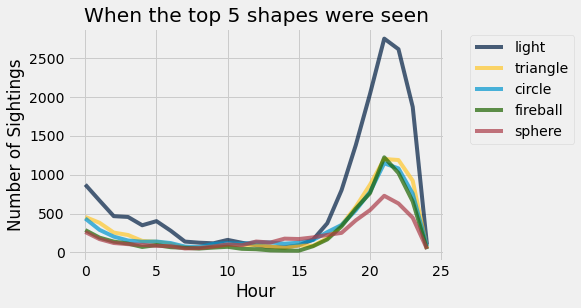

In [12]:
# Time of day and shape together
topshapes = shape_time.select('Hour','light', 'triangle', 'circle', 'fireball', 'sphere')
topshapes.plot('Hour')
plots.title('When the top 5 shapes were seen')
plots.ylabel('Number of Sightings')
plots.show()

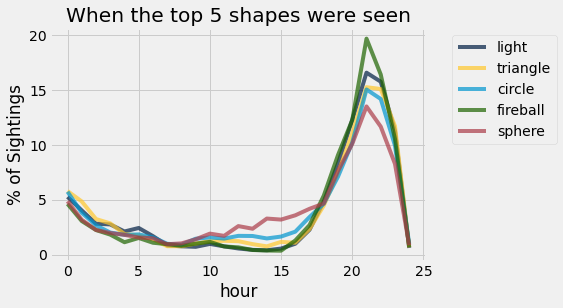

In [13]:
# Normalized
light = topshapes.column('light')/sum(topshapes.column('light'))*100
triangle = topshapes.column('triangle')/sum(topshapes.column('triangle'))*100
circle = topshapes.column('circle')/sum(topshapes.column('circle'))*100
fireball = topshapes.column('fireball')/sum(topshapes.column('fireball'))*100
sphere = topshapes.column('sphere')/sum(topshapes.column('sphere'))*100

scaled_topshapes = Table().with_columns('hour', topshapes.column('Hour'),
                                        'light', light,
                                        'triangle', triangle,
                                        'circle', circle,
                                        'fireball', fireball,
                                        'sphere', sphere)
scaled_topshapes.plot('hour')
plots.title('When the top 5 shapes were seen')
plots.ylabel('% of Sightings')
plots.show()

Mean,SD,2SD,z-score,p-value,95% CI,2012
4857.91,1163.53,7184.98,-2.14784,0.0158631,"[2577, 7138]",7357


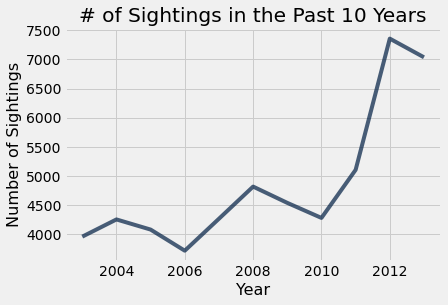

In [14]:
# Looking at the latest 10 years
tenyrs = timestable.group('Year').sort('Year', descending = True).where('Year', are.between(2003,2014))
avg = np.average(tenyrs.column('count'))
std = np.std(tenyrs.column('count'))
twostd = avg+(2*std)
zscore = (avg-7357)/(std)
CI = str([round(avg-1.96*std), round(avg+1.96*std)])

import scipy.stats as st
pvalue = st.norm.sf(abs(zscore))
pvalue

stat_table = Table().with_columns('Mean', avg,
                                 'SD', std,
                                 '2SD', twostd,
                                 'z-score', zscore,
                                 'p-value', pvalue,
                                 '95% CI', CI,
                                 '2012', 7357)
stat_table.show()
tenyrs.plot('Year')
plots.title('# of Sightings in the Past 10 Years')
plots.ylabel('Number of Sightings')
plots.show()

### Sighting Characteristics

In [15]:
# Reading in table
ufo = Table.read_table('scrubbed.csv')

In [16]:
# sighting duration
duration = ufo.column('duration (seconds)')
duration = np.char.strip(duration, chars='`')
duration = duration.astype(np.float)
ufo = ufo.drop('duration (seconds)')
ufo = ufo.with_columns('duration (seconds)', duration)

In [17]:
# Extracting only relevant information
c_table = Table().with_columns('Duration', duration, 'shape', ufo.column('shape'))
c2_table = c_table.select('Duration', 'shape')

In [18]:
# Adding in buckets
c2_table = c2_table.sort('Duration')
l = ['10 and below'] * 13361 
l +=  ['Between 11 and 60'] * 16116 
l += ['Between 61 and 300'] * 23956
l += ['Between 301 and 1000'] * 13072
l += ['Greater than 1000'] * 13827
c2_table = c2_table.with_columns('Bucket', l)

In [19]:
# Grouping by bucket
c2_groups = c2_table.group('Bucket')

Text(0.5, 1.0, 'UFO Sighting Duration Breakdown (seconds)')

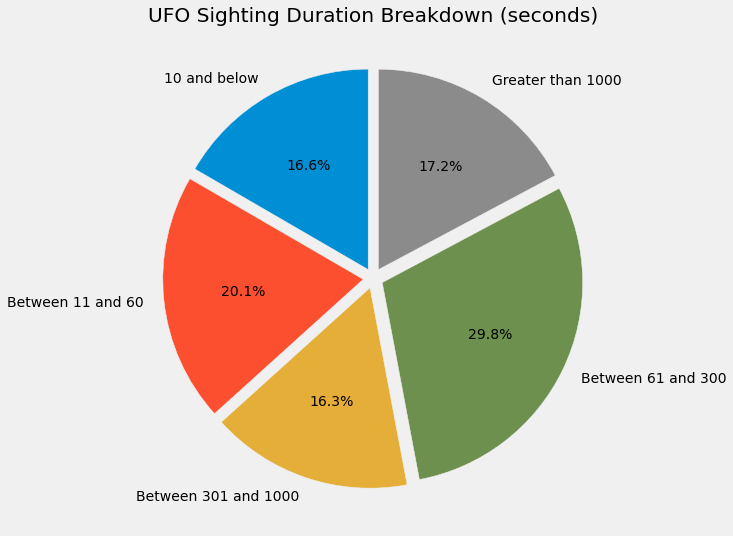

In [20]:
# Creating pie chart
explode = [0.05]*len(c2_groups.column('Bucket')) 
plots.figure(figsize=(8,12))
plots.pie(c2_groups.column('count'), labels=c2_groups.column('Bucket'), autopct='%1.1f%%', \
        explode=explode, startangle=90)
plots.title('UFO Sighting Duration Breakdown (seconds)')

In [21]:
# Selecting shapes and grouping negligible values into "other" group
s0_table = ufo.select('shape')
s_count = s0_table.group('shape')
s_count = s_count.sort('count', descending=True).remove(4).remove(4)
other = np.sum(s_count.take[7:len(s_count.column('shape'))].column('count'))
s_count = s_count.take[:7]
s_count = s_count.append(['other', other])

Text(0.5, 1.0, 'UFO Shape Breakdown')

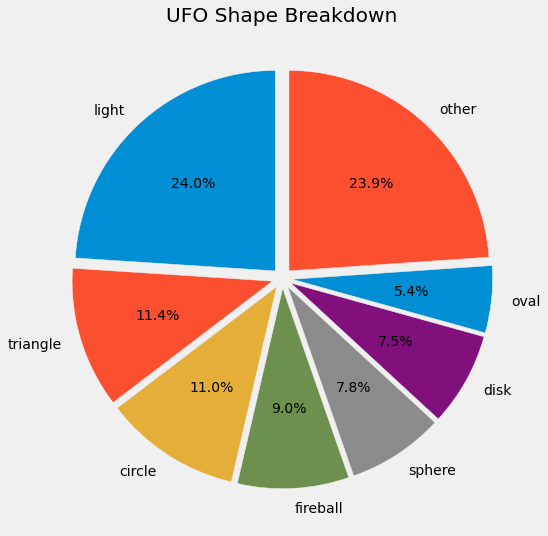

In [22]:
# Creating pie chart
explode = [0.05]*len(s_count.column('shape')) 
plots.figure(figsize=(8,12))
plots.pie(s_count.column('count'), labels=s_count.column('shape'), autopct='%1.1f%%', \
        explode=explode, startangle=90)
plots.title('UFO Shape Breakdown')

In [23]:
s0_table.group('shape')

shape,count
changed,1
changing,1962
chevron,952
cigar,2057
circle,7608
cone,316
crescent,2
cross,233
cylinder,1283
delta,7


### Spatial Patterns

In [24]:
ufo = Table.read_table('scrubbed.csv')
location = ufo.select("city", "state", "country")

In [25]:
# Extracting US sightings
us = location.where("country", are.equal_to("us"))

In [26]:
states = us.group("state").exclude(7).exclude(38).with_column('states', np.arange(1,51))

In [27]:
populations = states.with_columns('Populations', 
                                  make_array(
                                      731545,
                                      4903185,
                                      3017804,
                                      7278717,
                                      39512223,
                                      5758736,
                                      3565287,
                                      973764,
                                      21477737,
                                      10617423,
                                      1415872,
                                      3155070,
                                      1787065,
                                      12671821,
                                      6732219,
                                      2913314,
                                      4467673,
                                      4648794,
                                      6892503,
                                      6045680,
                                      1344212,
                                      9986857,
                                      5639632,
                                      6137428,
                                      2976149,
                                      1068778,
                                      10488084,
                                      762062,
                                      1934408,
                                      1359711,
                                      8882190,
                                      2096829,
                                      3080156,
                                      19453561,
                                      11689100,
                                      3956971,
                                      4217737,
                                      12801989,
                                      1059361,
                                      5148714,
                                      884659,
                                      6829174,
                                      28995881,
                                      3205958,
                                      8535519,
                                      623989,
                                      7614893,
                                      5822434,
                                      1792147,
                                      578759))

In [28]:
# Normalizing to population
pc_array = populations.column('count') / populations.column('Populations') * 100000
percap = populations.with_columns('Population Per Capita', pc_array)

Text(0, 0.5, 'State')

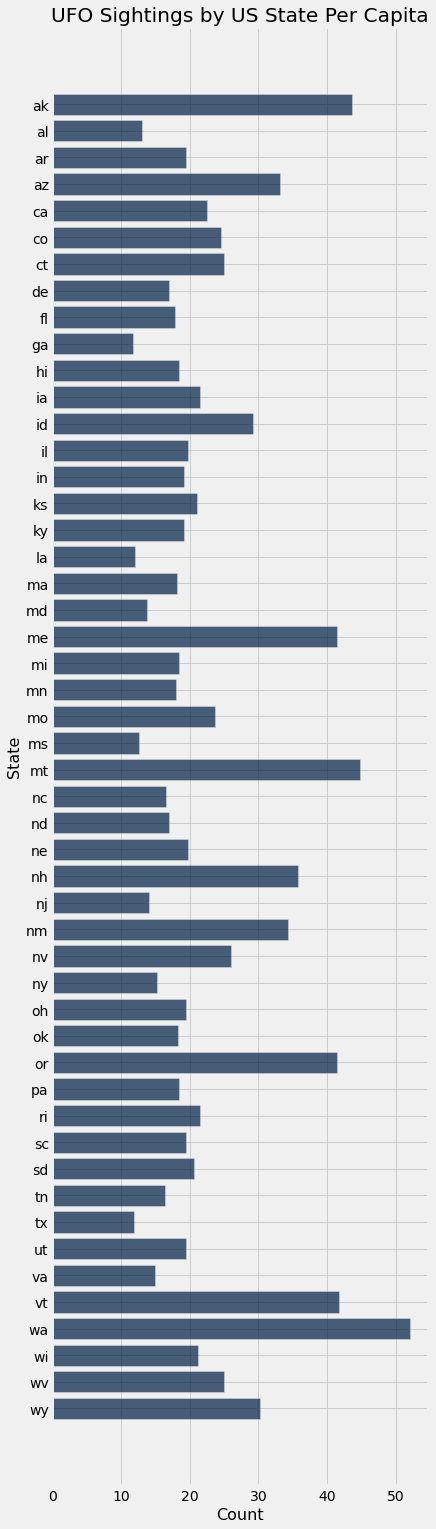

In [29]:
percap.barh('state', 'Population Per Capita')
plots.title("UFO Sightings by US State Per Capita")
plots.xlabel('Count')
plots.ylabel('State')

In [30]:
lower = percap.column('state')
upper = np.char.upper(lower)

In [31]:
percap2 = Table().with_columns('state', upper, 'count per cap', pc_array)

In [32]:
# Contructing heat map for better visualization
import plotly.express as px

fig = px.choropleth(locations=percap2.column('state'), locationmode="USA-states", \
                    color=percap2.column('count per cap'), scope="usa", \
                    color_continuous_scale="geyser", range_color=(10, 55))
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [77]:
comparison = percap.sort('Population Per Capita', descending = True).exclude(np.arange(5,45))
comp1 = comparison.exclude(np.arange(5, 10))
comp2 = comparison.exclude(np.arange(0, 5))

state,count,states,Populations,Population Per Capita
al,642,2,4903185,13.0935
ms,375,25,2976149,12.6002
la,558,18,4648794,12.0031
tx,3447,43,28995881,11.8879
ga,1255,10,10617423,11.8202


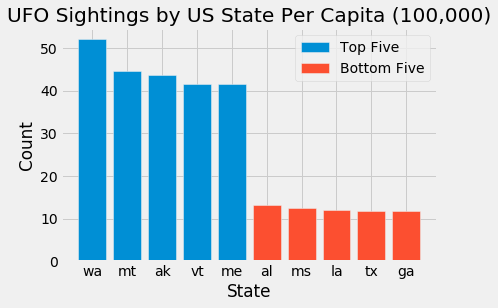

In [78]:
# Top five and lowest five states sightings per capita
plots.bar(comp1.column('state'), comp1.column('Population Per Capita'), label='Top Five')
plots.bar(comp2.column('state'), comp2.column('Population Per Capita'), label='Bottom Five')
plots.title("UFO Sightings by US State Per Capita (100,000)")
plots.xlabel('State')
plots.ylabel('Count')
plots.legend()

In [159]:
# Statistical analysis of Washington state's significance in UFO sightings 
percap.sort('count', descending=True)

state,count,states,Populations,Population Per Capita
ca,8912,5,39512223,22.555
wa,3966,47,7614893,52.0822
fl,3835,9,21477737,17.8557
tx,3447,43,28995881,11.8879
ny,2980,34,19453561,15.3185
il,2499,14,12671821,19.7209
az,2414,4,7278717,33.1652
pa,2366,38,12801989,18.4815
oh,2275,35,11689100,19.4626
mi,1836,22,9986857,18.3842


In [164]:
len(us.column('state'))

65114

In [172]:
us.group('state').sort('count', descending=True)

state,count
ca,8912
wa,3966
fl,3835
tx,3447
ny,2980
il,2499
az,2414
pa,2366
oh,2275
mi,1836


In [165]:
wash_pop = 7600000
us_pop = 328000000
n = 65114
p = wash_pop / us_pop
np.random.binomial(n, p)

1547

In [166]:
n*p

1508.739024390244

In [167]:
wash_count = 3966  # actual amount of sightings occuring in Washington state in the dataset

Text(0.5, 1.0, 'Binomial Distribution of Washington Counts')

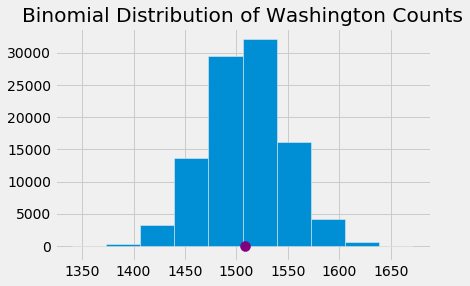

In [169]:
# Binomial distirbution simulation
nsim = 100000
plots.hist(np.random.binomial(n,p,nsim)) 
plots.scatter(n*p, -5, color='purple', s=100, zorder=2, label='Expected Value')
plots.title('Binomial Distribution of Washington Counts')


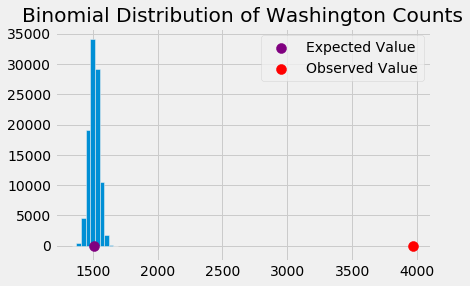

In [170]:
# Comparing above distribution to observed value
plots.hist(np.random.binomial(n,p,100000))
plots.scatter(n*p, -5, color='purple', s=100, zorder=2, label='Expected Value')
plots.scatter(wash_count, -5, color='red', s=100, zorder=2, label='Observed Value')
plots.title('Binomial Distribution of Washington Counts')
plots.legend()

*We can reject hypothesis that the amount of Washington sightings follows a binomial distribution*

